# Setup

Importing libraries, reaading the dataframe from the excel file, setting the seed for reproducibility and setting <code>ignore warnings</code>.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
# import xgboost

df = pd.read_excel('Needs.xls')

seed = 69

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

The first column (<code>ID</code>) is deleted, since it is useless for classification purposes.

In [2]:
df.drop(labels='ID', axis=1, inplace=True)

The dataframe is shuffled and split into samples (<code>x_df</code>) and targets (<code>y_inc_df</code> and <code>y_acc_df</code>). The target dataframes are two since two different classifiers will be used to predict <code>income investment propensity</code> and <code>accumulation investment propensity</code>.

In [3]:
df = df.sample(frac = 1, random_state = seed)

x_df = df[['Age', 'Gender', 'FamilyMembers', 'FinancialEducation', 'RiskPropensity', 'Income', 'Wealth']]
y_inc_df = df['IncomeInvestment']
y_acc_df = df['AccumulationInvestment']

# Data Exploration

Feature distributions are plotted.

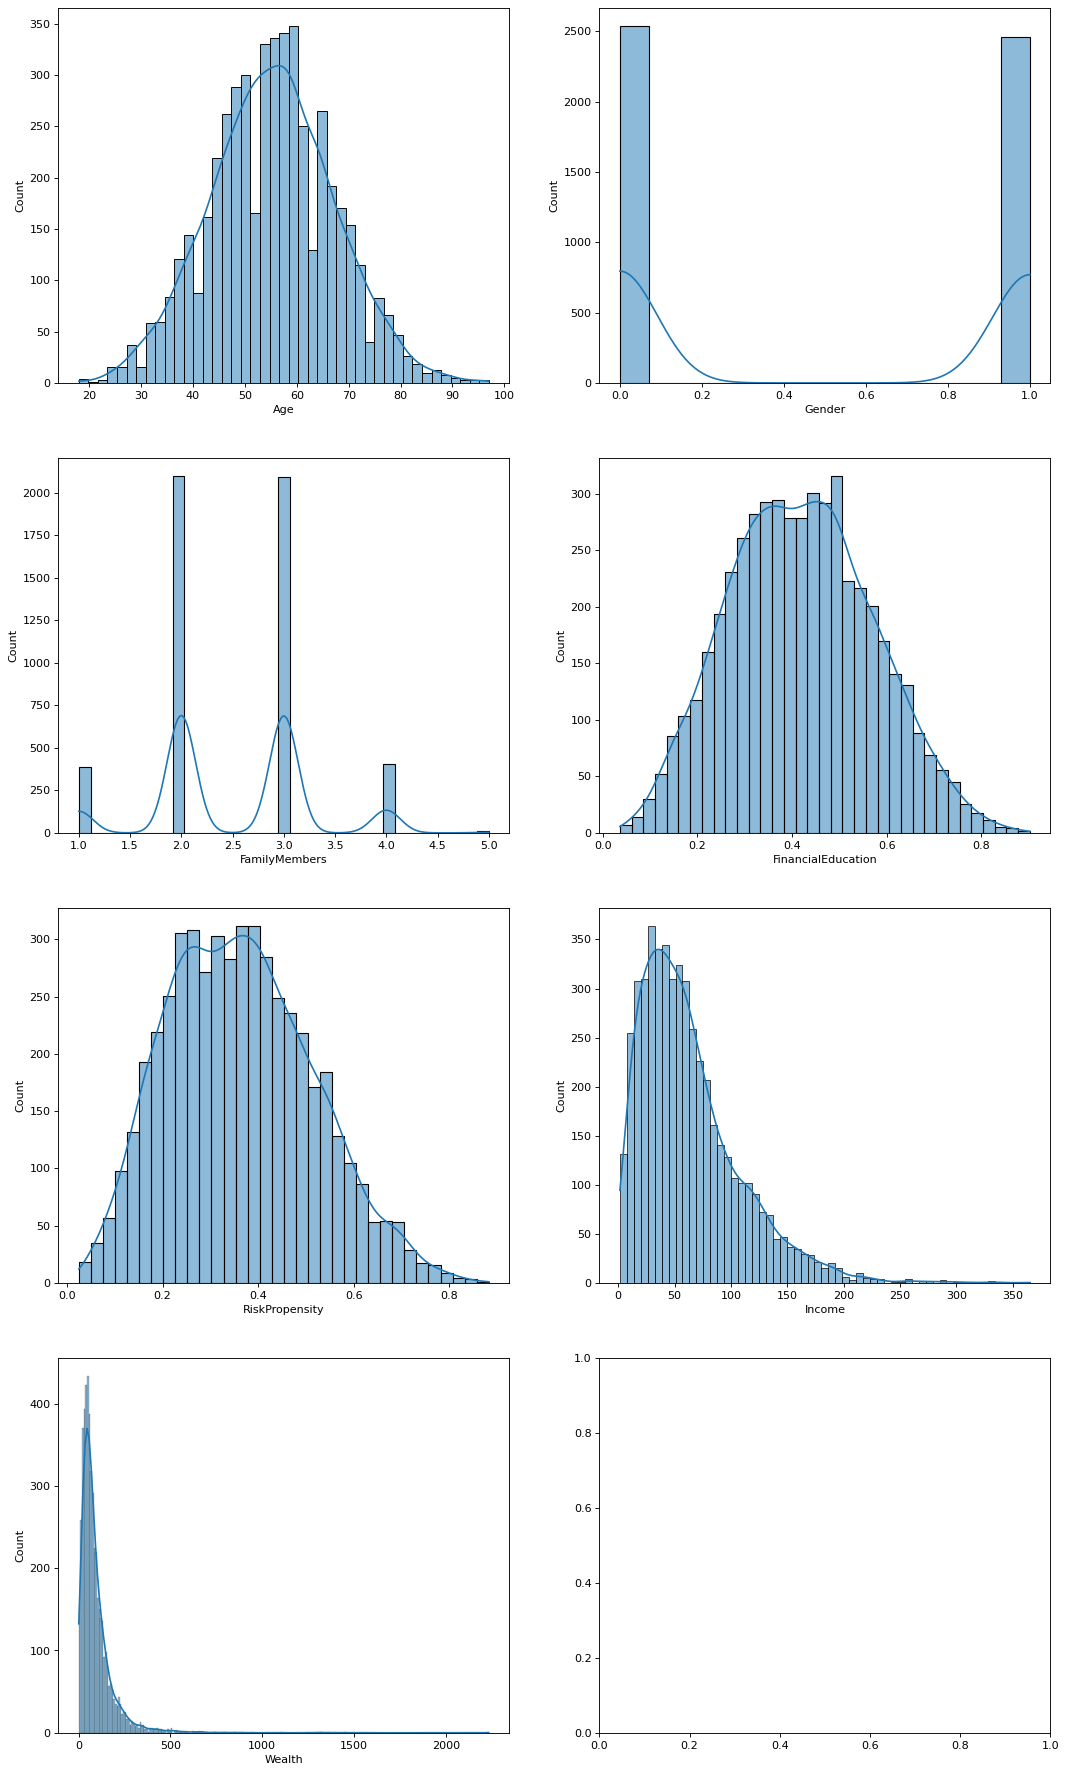

In [4]:
fig, axes = plt.subplots(4, 2, figsize=(16,28), dpi=80)
features = x_df.columns

row = column = 0

for f in features:
    ax = axes[row][column]

    sns.histplot(data=x_df, x=f, ax=ax, kde=True)

    column = column + 1
    if column % 2 == 0:
        column = 0
        row = row + 1 

The scatterplots of each feature versus the other using the labels <code>IncomeInvestment</code> and <code>AccumulationInvestment</code> as grouping variables are plotted. This is done mainly to determine whether one or more features could be considered useless for classification purposes.

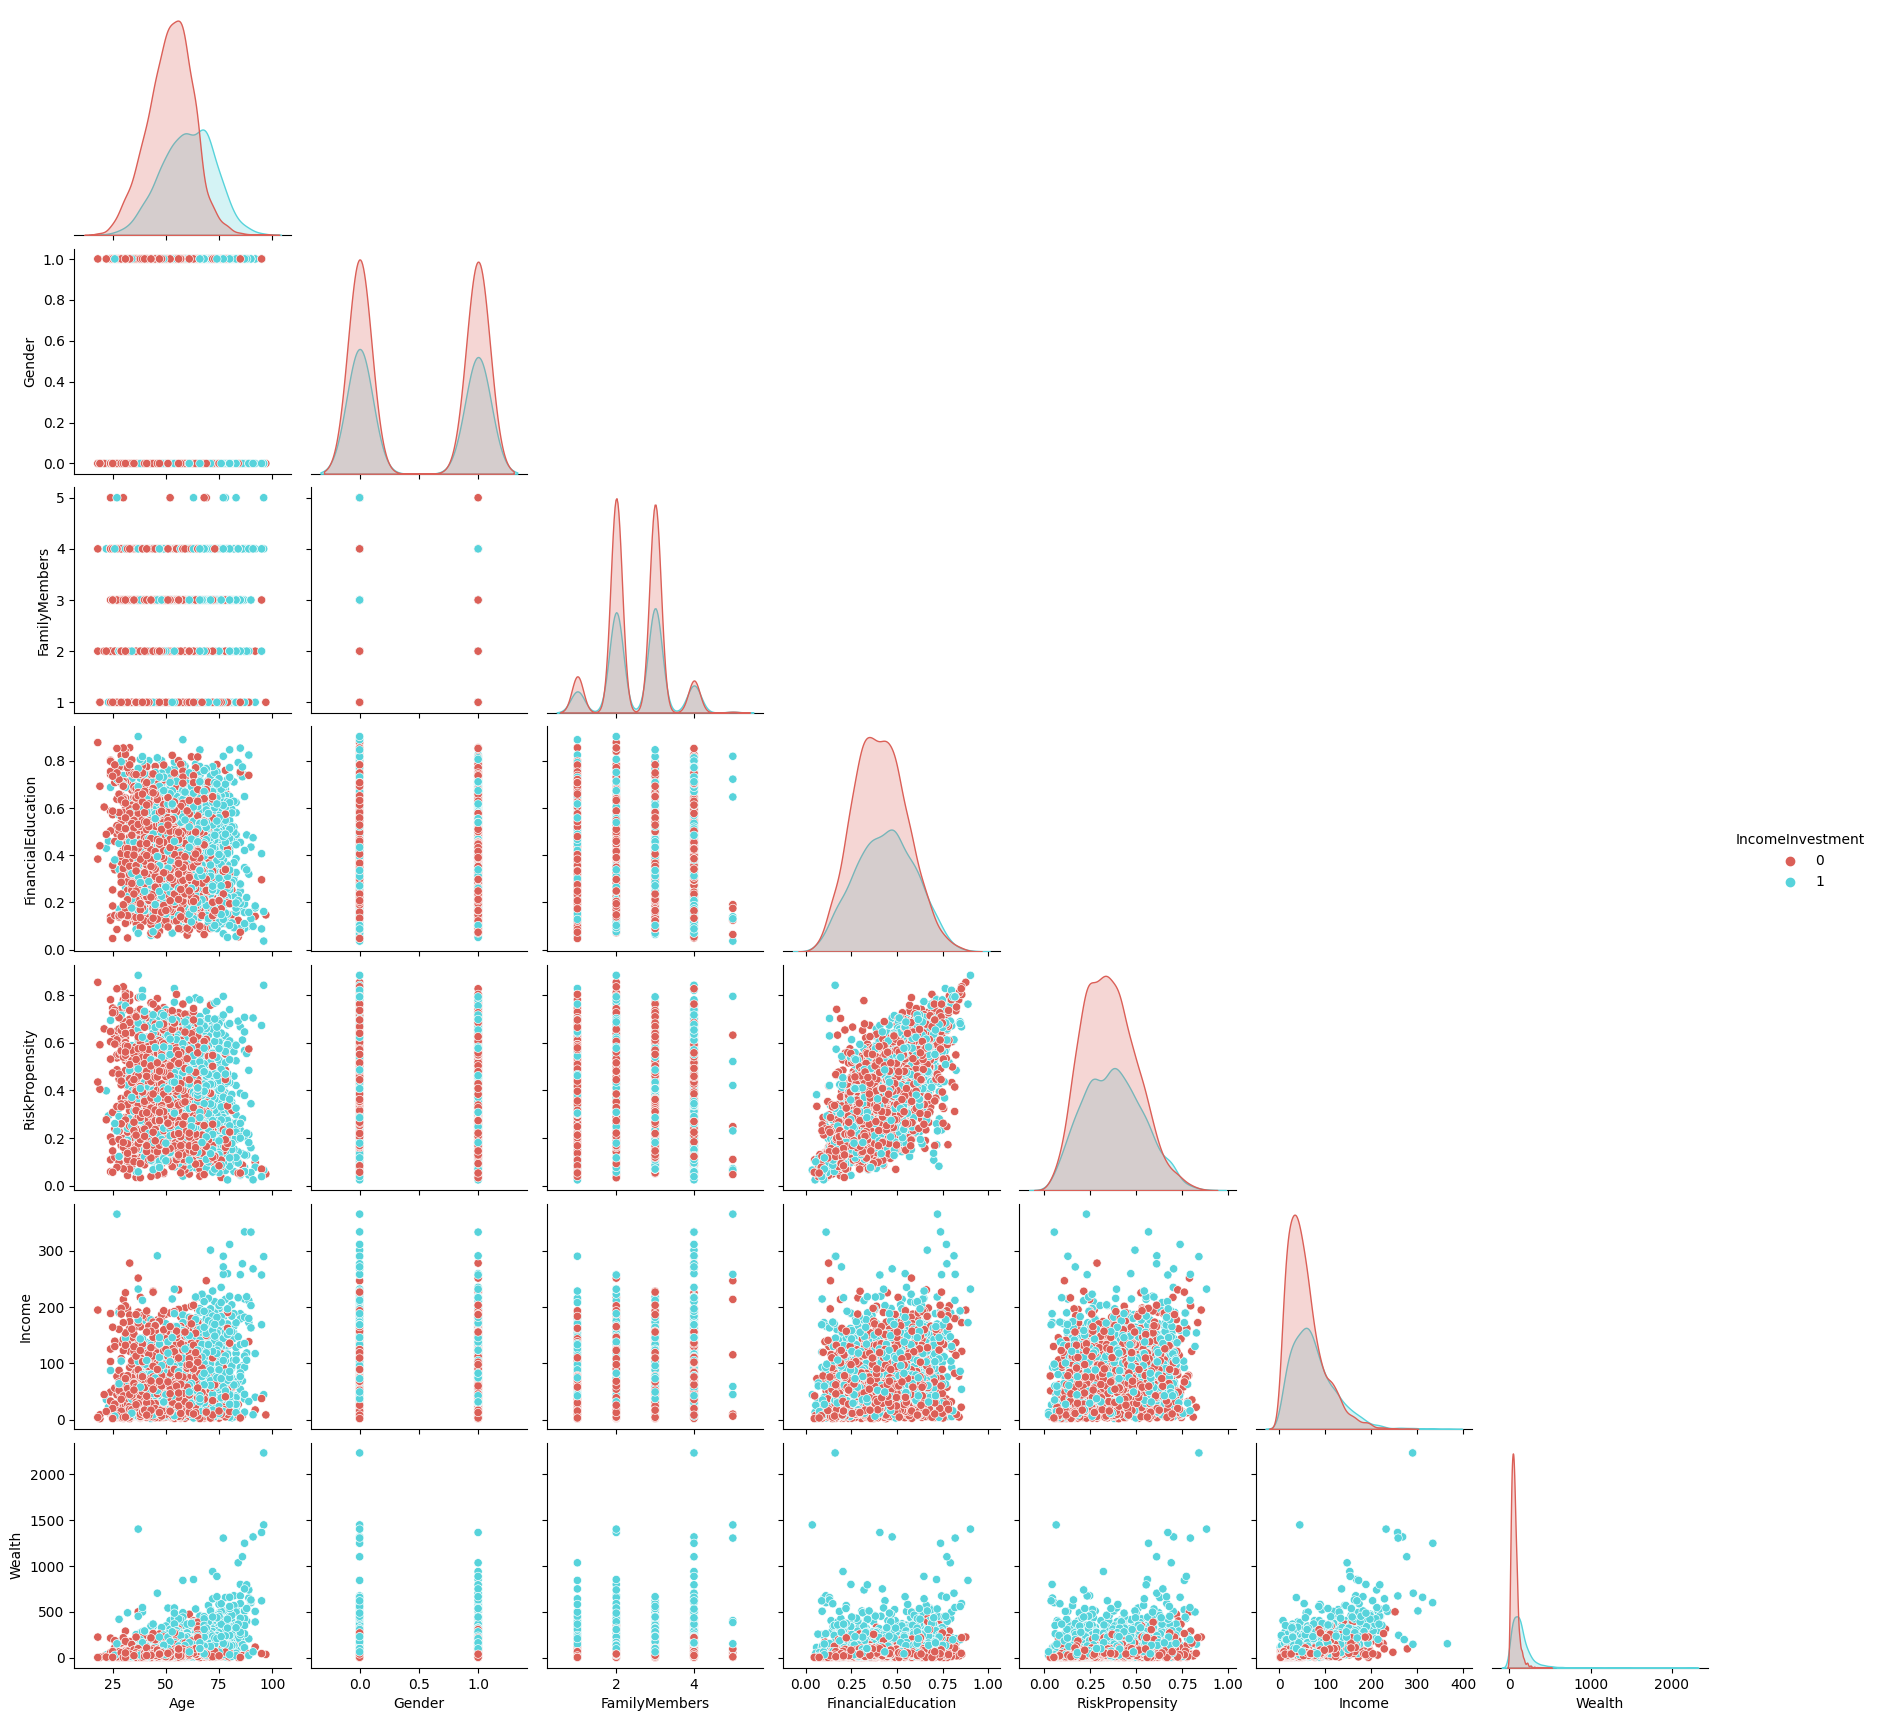

In [5]:
colour = sns.color_palette("hls", 2)
_ = sns.pairplot(pd.concat([x_df, y_inc_df], axis = 1), 
             hue= 'IncomeInvestment', 
             corner = True, 
             palette = colour, 
             vars = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation', 'RiskPropensity', 'Income', 'Wealth'])

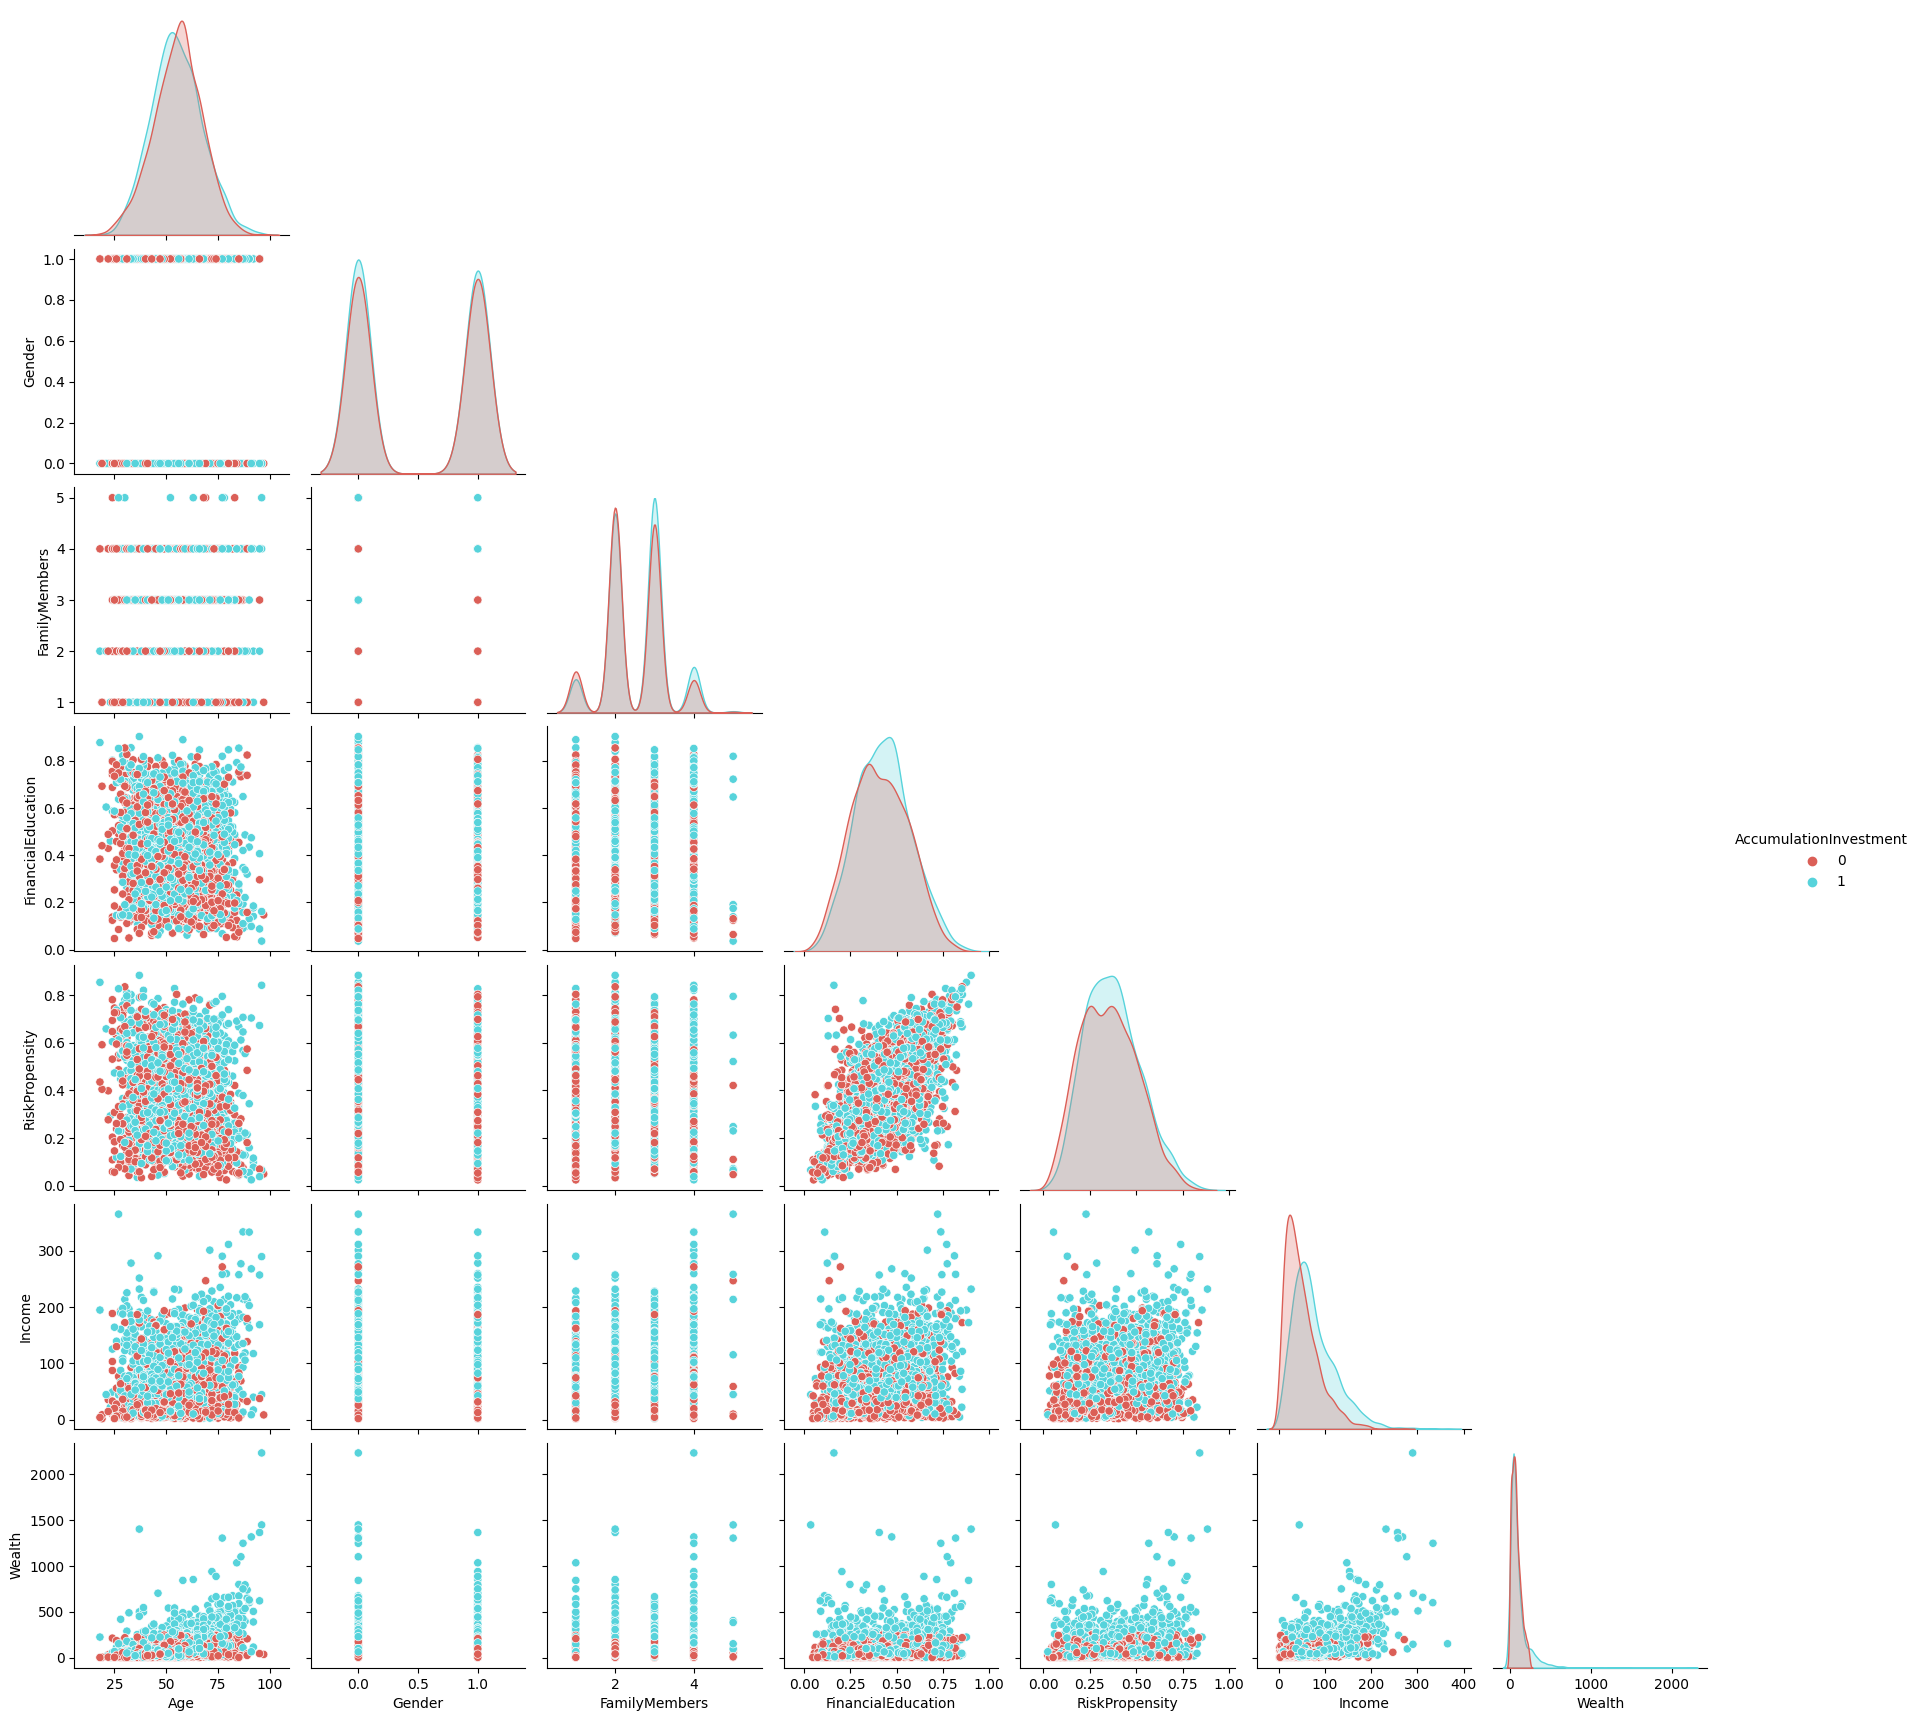

In [6]:
colour = sns.color_palette("hls", 2)
_ = sns.pairplot(pd.concat([x_df, y_acc_df], axis = 1), 
             hue= 'AccumulationInvestment', 
             corner = True, 
             palette = colour, 
             vars = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation', 'RiskPropensity', 'Income', 'Wealth'])

<code>Considerazioni sui plots (gender e 'forse' famiglia possono essere eliminati)</code>

# Data preprocessing

<code>Gender</code> feature is dropped since it showed no relevance in data exploration.

In [7]:
x_df.drop(labels='Gender', axis=1, inplace=True)

Data exploration showed that <code>Wealth</code> and <code>Income</code> features are not gaussian distributed. A power law transformation is applied in order to modify the distribution related to these features. $0.1$ and $0.3$ values showed to work well in the two cases (transformed features are approximately gaussian distributed).

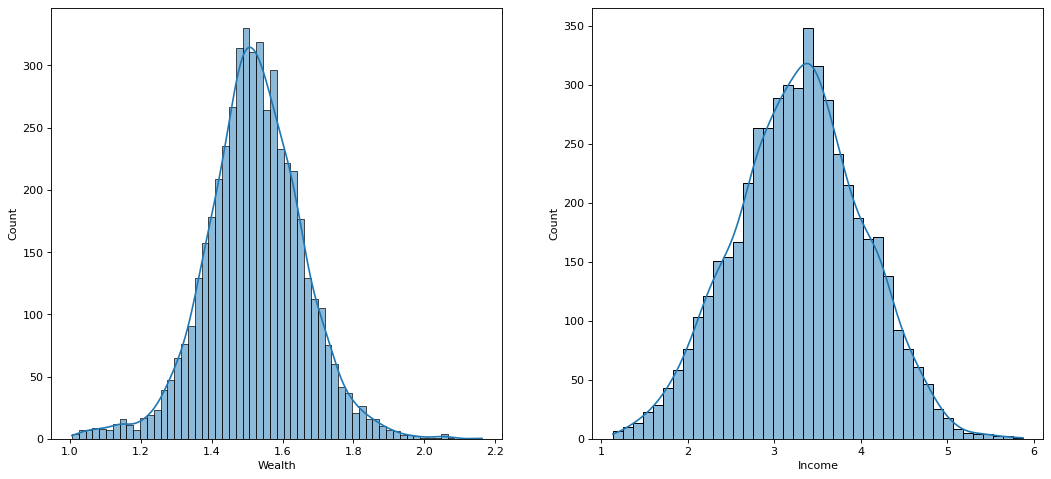

In [8]:
wealth_power = 0.1
income_power = 0.3

x_df['Wealth'] = x_df['Wealth']**wealth_power
x_df['Income'] = x_df['Income']**income_power

fig, axes = plt.subplots(1, 2, figsize=(16,7), dpi=80)
_ = sns.histplot(data=x_df, x='Wealth', ax=axes[0], kde=True)
_ = sns.histplot(data=x_df, x='Income', ax=axes[1], kde=True)

Standardization ($\mu =0\text{, }\sigma ^2=1$) is applied feature-wise to the dataframe. Mean and standard deviation values are stored since they may be useful later to transform back to the original values.

In [9]:
features = x_df.columns
indexes = np.arange(len(features))

means = np.empty(len(features))
stds = np.empty(len(features))

for f, i in zip(features, indexes):
    means[i] = np.mean(x_df[f])
    stds[i] = np.std(x_df[f])
    x_df[f] = (x_df[f] - means[i]) / stds[i]

# Classification

## First model

Dataset split ($70\%$ training, $15\%$ valdation, $15\%$ testing).

In [10]:
from sklearn.model_selection import train_test_split

# first split between training and validation + testing
x_train, x_val_test, y_inc_train, y_inc_val_test = train_test_split(x_df, y_inc_df, test_size=0.3, random_state=seed)
x_train, x_val_test, y_acc_train, y_acc_val_test = train_test_split(x_df, y_acc_df, test_size=0.3, random_state=seed)

# second split between validation and testing
x_val, x_test, y_inc_val, y_inc_test = train_test_split(x_val_test, y_inc_val_test, test_size=0.5, random_state=seed)
x_val, x_test, y_acc_val, y_acc_test = train_test_split(x_val_test, y_acc_val_test, test_size=0.5, random_state=seed)

<code>Verificare perché non funziona la regularization con la logistic regression!</code> (escono gli stessi risultati con e senza regularization)

<code>Qua ho fatto solamente la classificazione per l'income, andrebbe fatto anche quello per l'accumulation!</code>

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

log_reg = LogisticRegression(penalty='l2')
log_reg.fit(x_train, y_inc_train)
y_pred = log_reg.predict(x_val)

## Results visualization

Confusion matrix is plotted.

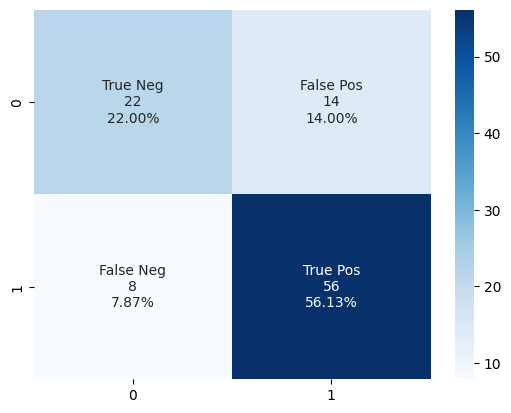

In [12]:
cf_matrix = (confusion_matrix(y_inc_val, y_pred, labels=[1, 0], sample_weight=None) / len(y_pred) * 100)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
_ = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [13]:
print(f'Accuracy = {accuracy_score(y_inc_val, y_pred):.3f}')
print(f'Recall = {recall_score(y_inc_val, y_pred):.3f}')
print(f'Precision = {precision_score(y_inc_val, y_pred):.3f}')
print(f'F1score = {f1_score(y_inc_val, y_pred):.3f}')

Accuracy = 0.781
Recall = 0.611
Precision = 0.737
F1score = 0.668


## Feature Engineering

In [143]:
# dropping risk pronensity feature since we only want to use it later
# x_df.drop('RiskPropensity', axis = 1)

Normalization and power transformation are reversed before creating <code>wealth/income</code> variable and plotting it.

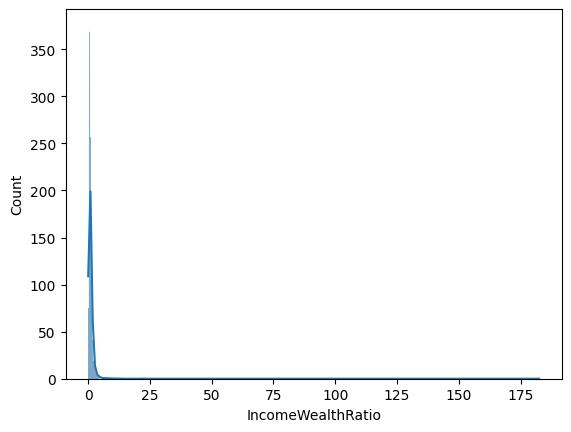

In [14]:
for f, i in zip(features, indexes):
    x_df[f] = x_df[f] * stds[i] + means[i]

x_df['Wealth'] = x_df['Wealth']**(1.0/wealth_power)
x_df['Income'] = x_df['Income']**(1.0/income_power)

x_df['IncomeWealthRatio'] = x_df['Income'] / x_df['Wealth']

_ = sns.histplot(data=x_df, x='IncomeWealthRatio', kde=True)

The power transformation is applied to <code>wealth/income</code> variable to modify its distribution to gaussian-like.

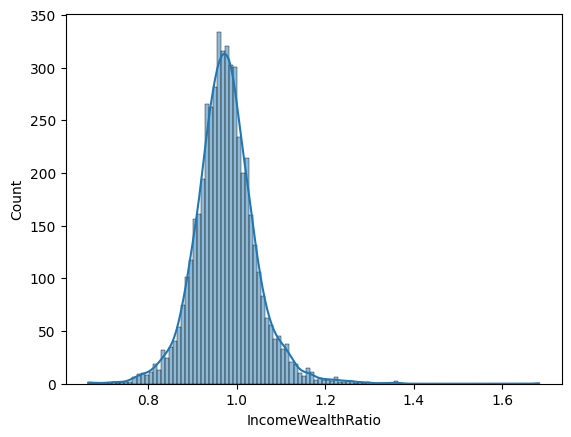

In [15]:
wealth_income_power = 0.1
x_df['IncomeWealthRatio'] = x_df['IncomeWealthRatio']**wealth_income_power
_ = sns.histplot(data=x_df, x='IncomeWealthRatio', kde=True)

The data preprocessing already discussed above is re-applied to data in order to prepare it for classification.

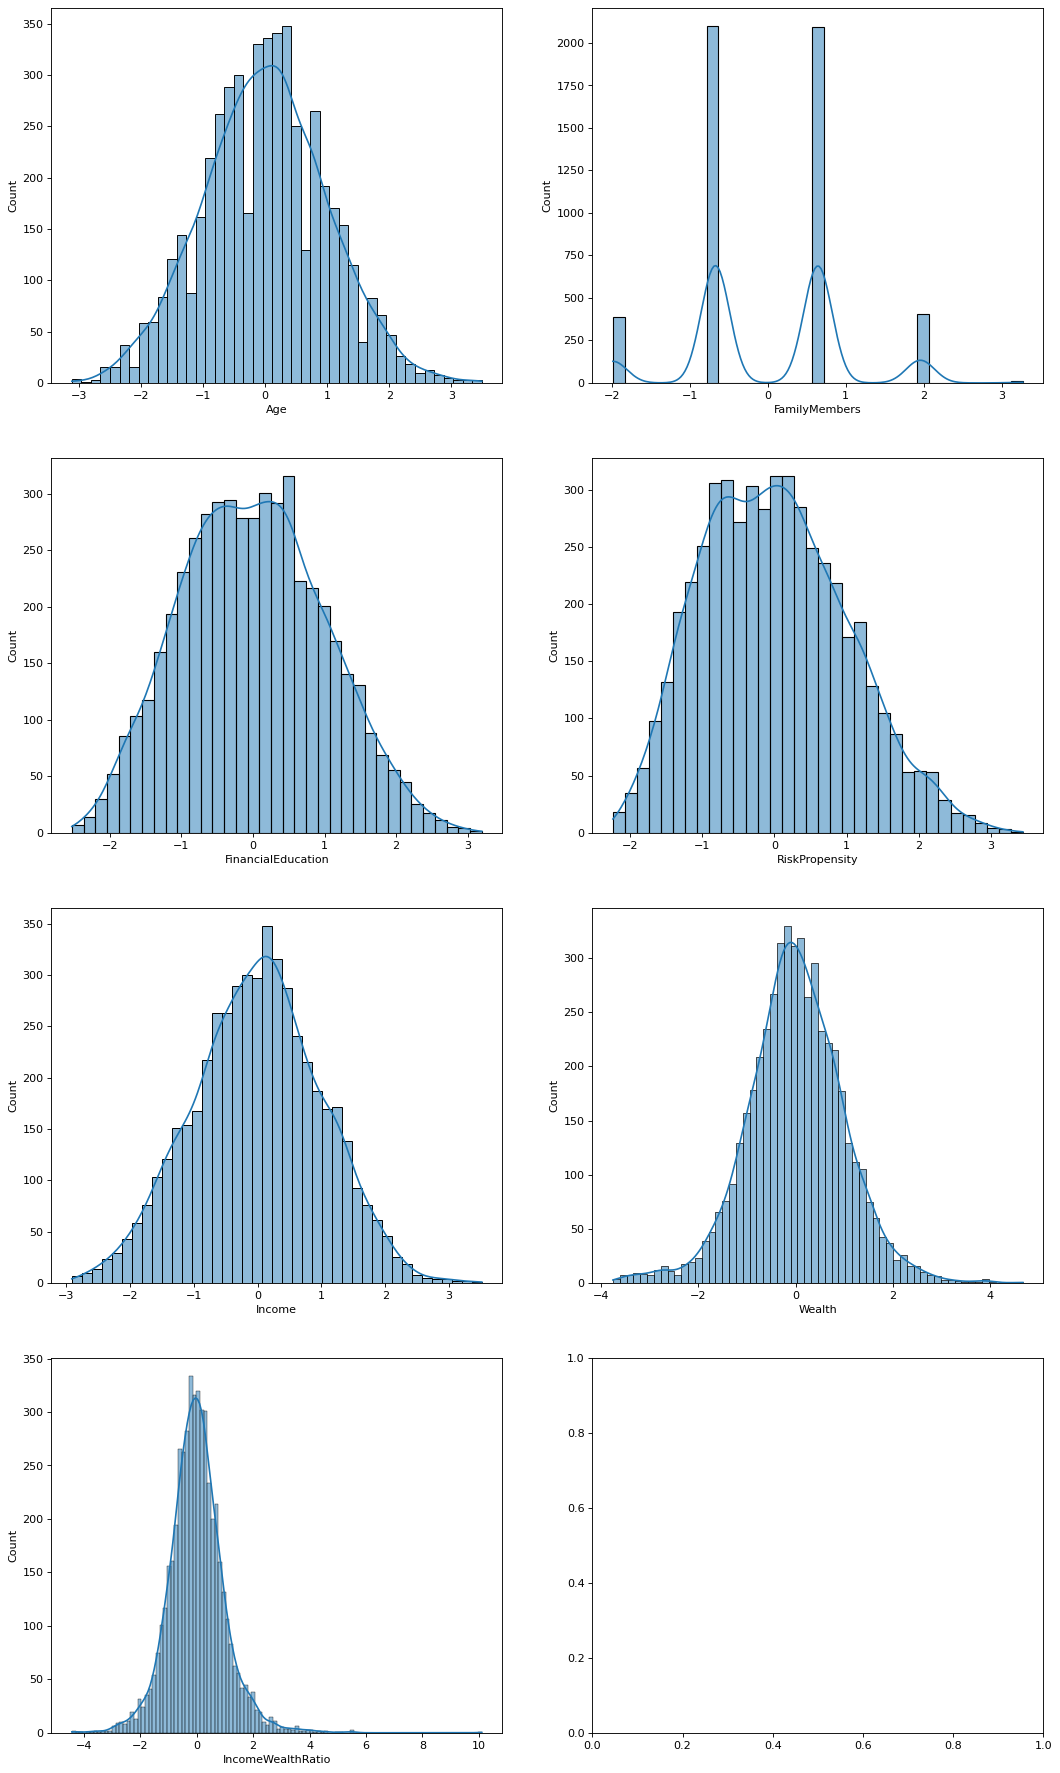

In [16]:
x_df['Wealth'] = x_df['Wealth']**0.1
x_df['Income'] = x_df['Income']**0.3

features = x_df.columns
indexes = np.arange(len(features))

means = np.empty(len(features))
stds = np.empty(len(features))

for f, i in zip(features, indexes):
    means[i] = np.mean(x_df[f])
    stds[i] = np.std(x_df[f])
    x_df[f] = (x_df[f] - means[i]) / stds[i]

fig, axes = plt.subplots(4, 2, figsize=(16,28), dpi=80)
row = column = 0

for f in features:
    ax = axes[row][column]

    sns.histplot(data=x_df, x=f, ax=ax, kde=True)

    column = column + 1
    if column % 2 == 0:
        column = 0
        row = row + 1 

## New model

Data is split again into training, validation and testing sets, logistic regression is fitted again on training data.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

# first split between training and validation + testing
x_train, x_val_test, y_inc_train, y_inc_val_test = train_test_split(x_df, y_inc_df, test_size=0.3, random_state=seed)
x_train, x_val_test, y_acc_train, y_acc_val_test = train_test_split(x_df, y_acc_df, test_size=0.3, random_state=seed)

# second split between validation and testing
x_val, x_test, y_inc_val, y_inc_test = train_test_split(x_val_test, y_inc_val_test, test_size=0.5, random_state=seed)
x_val, x_test, y_acc_val, y_acc_test = train_test_split(x_val_test, y_acc_val_test, test_size=0.5, random_state=seed)

# fitting data with logistic regression
log_reg = LogisticRegression(penalty='l2')
log_reg.fit(x_train, y_inc_train)
y_pred = log_reg.predict(x_val)

Confusion matrix is plotted.

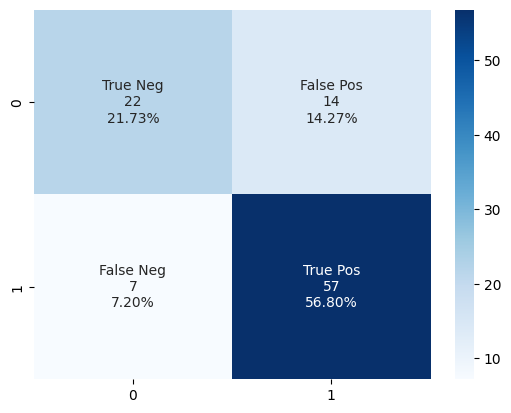

In [18]:
cf_matrix = (confusion_matrix(y_inc_val, y_pred, labels=[1, 0], sample_weight=None) / len(y_pred) * 100)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
_ = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [19]:
print(f'Accuracy = {accuracy_score(y_inc_val, y_pred):.3f}')
print(f'Recall = {recall_score(y_inc_val, y_pred):.3f}')
print(f'Precision = {precision_score(y_inc_val, y_pred):.3f}')
print(f'F1score = {f1_score(y_inc_val, y_pred):.3f}')

Accuracy = 0.785
Recall = 0.604
Precision = 0.751
F1score = 0.669


<code>Risultati leggermente migliori di prima, ma non di molto!</code>

<code>Qua eventualmente andrebbero provati altri modelli per la classificazione, e una volta scelto il migliore basandosi sull'errore sul validation set possiamo valutare l'errore sul test set.</code>

<code>Va fatta la stessa cosa per l'accumulation!</code>

# Recommendation system

The products list is read from the excel file.

In [20]:
products = pd.read_excel('Needs.xls', 'Products')

The products list is split between <code>income_products</code> and <code>accumulation_products</code>.

In [21]:
income_products = products[products['Type'] == 1]
accumulation_products = products[products['Type'] == 0]

The products are sorted in increasing <code>Risk</code> order.

In [22]:
income_products.sort_values('Risk', axis = 0, inplace=True)
accumulation_products.sort_values('Risk', axis = 0, inplace=True)

The minimum and maximum <code>RiskPropensity</code> values are inspected from the dataset in order to establish lower and upper bouds.

In [23]:
max_risk = np.max(df['RiskPropensity'])
min_risk = np.min(df['RiskPropensity'])
print(f'max risk = {max_risk:.3f}')
print(f'min risk = {min_risk:.3f}')

max risk = 0.883
min risk = 0.025


Adding <code>MinRisk</code> and <code>MaxRisk</code> columns to the products dataframes which will be used to assign products to clients.

In [24]:
for df in [income_products, accumulation_products]:

    lower_bound = []
    upper_bound = []

    for i in range(len(df['Risk'])):
        if (i==0):
            lower_bound.append(min_risk)
            upper_bound.append((df.iloc[i]['Risk'] + df.iloc[i+1]['Risk']) / 2.0)
        elif (i==len(df['Risk'])-1):
            lower_bound.append((df.iloc[i]['Risk'] + df.iloc[i-1]['Risk']) / 2.0)
            upper_bound.append(max_risk)
        else:
            lower_bound.append((df.iloc[i]['Risk'] + df.iloc[i-1]['Risk']) / 2.0)
            upper_bound.append((df.iloc[i]['Risk'] + df.iloc[i+1]['Risk']) / 2.0)

    df['MinRisk'] = lower_bound
    df['MaxRisk'] = upper_bound

The function that assigns the best product to a client given its <code>RiskPropensity</code> and either the <code>income_products</code> or <code>accumulation_products</code> dataset is defined.

In [25]:
def assign_product(risk, df):
    for i in range(len(df['IDProduct'])):
        if (risk >= df.iloc[i]['MinRisk'] and risk <= df.iloc[i]['MaxRisk']):
            return df.iloc[i]['IDProduct']

Qua volendo si potrebbe implementare il codice per fare "tutto":

1. Si parte dal dataset "grezzo" e dai modelli migliori per i classifier;
2. Si fanno le predict di <code>income_products</code> e <code>accumulation_products</code> per ogni cliente del dataset;
3. Si stabilisce se si deve assegnare al cliente un prodotto <code>income</code> o <code>accumulation</code> (banale se la prediction è positiva per una delle due labels, meno banale se la predict è 0 per entrambi o 1 per entrambi);
4. Si assegna a ogni cliente un prodotto con <code>assign_product</code> partendo dalla sua <code>RiskPropensity</code> e dal dataset scelto al punto 3.